# Overview of osmnx
Here we demo simple usage of osmnx package to extract data and conduct simple analysis.

Source: https://github.com/gboeing/osmnx-examples

In [17]:
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

ox.__version__

'1.8.0'

In [1]:
# !pip install osmnx

In [2]:
# turn response caching off
ox.settings.use_cache = False

# turn it back on and turn on/off logging to your console
ox.settings.use_cache = True
ox.settings.log_console = False

# Download city boundaries

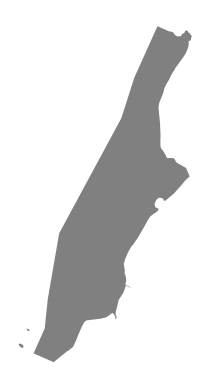

In [3]:
# get the boundary polygon for manhattan, project it, and plot it
city = ox.geocode_to_gdf("Manhattan, New York, USA")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")

# 2. Download Street Network
OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, or GeoPackages for later use. 

In [4]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")

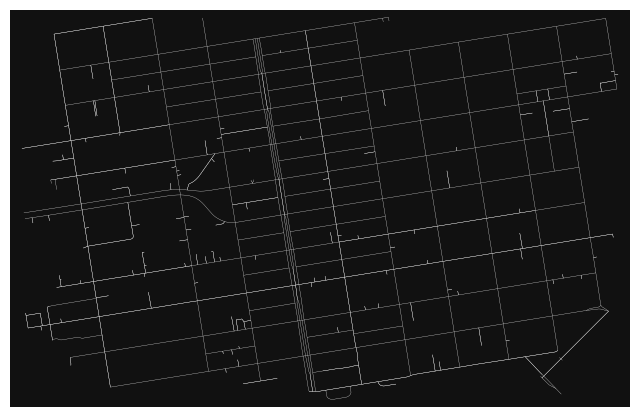

In [5]:
fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

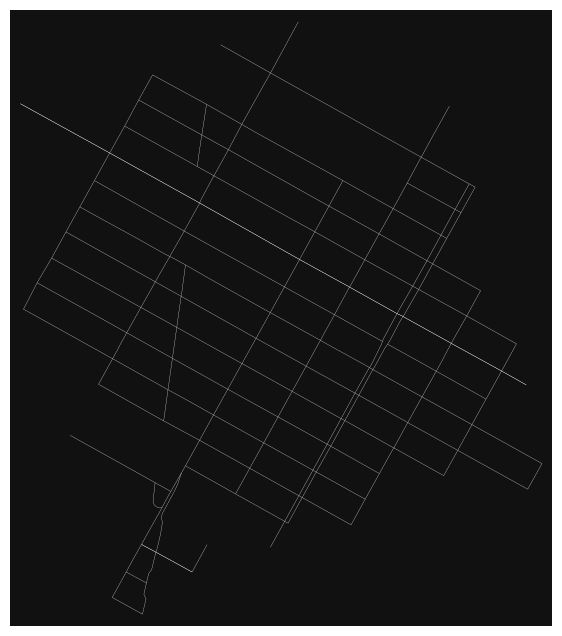

In [6]:
# network from address, including only nodes within 1km along the network from the address
G = ox.graph_from_address(
    address="350 5th Ave, New York, NY",
    dist=1000,
    dist_type="network",
    network_type="drive",
)

# you can project the network to UTM (zone calculated automatically)
G_projected = ox.project_graph(G)
fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

In [7]:
# convert the graph to geojson
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,highway,street_count,geometry
osmid,,,,,
42427786,40.745301,-73.986846,traffic_signals,4,POINT (-73.98685 40.74530)
42427787,40.746048,-73.988610,traffic_signals,4,POINT (-73.98861 40.74605)
42427797,40.746666,-73.990068,traffic_signals,4,POINT (-73.99007 40.74667)
42427805,40.747872,-73.992924,traffic_signals,4,POINT (-73.99292 40.74787)
42428192,40.739866,-73.989565,traffic_signals,4,POINT (-73.98957 40.73987)


<Axes: >

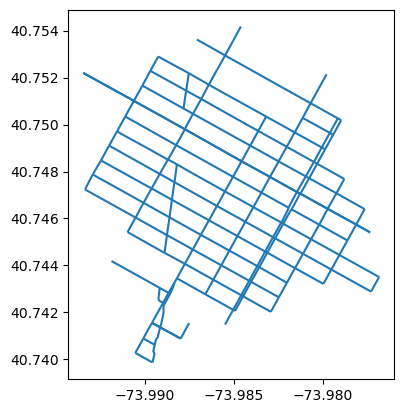

In [8]:
gdf_edges.plot()

# Get building footprint

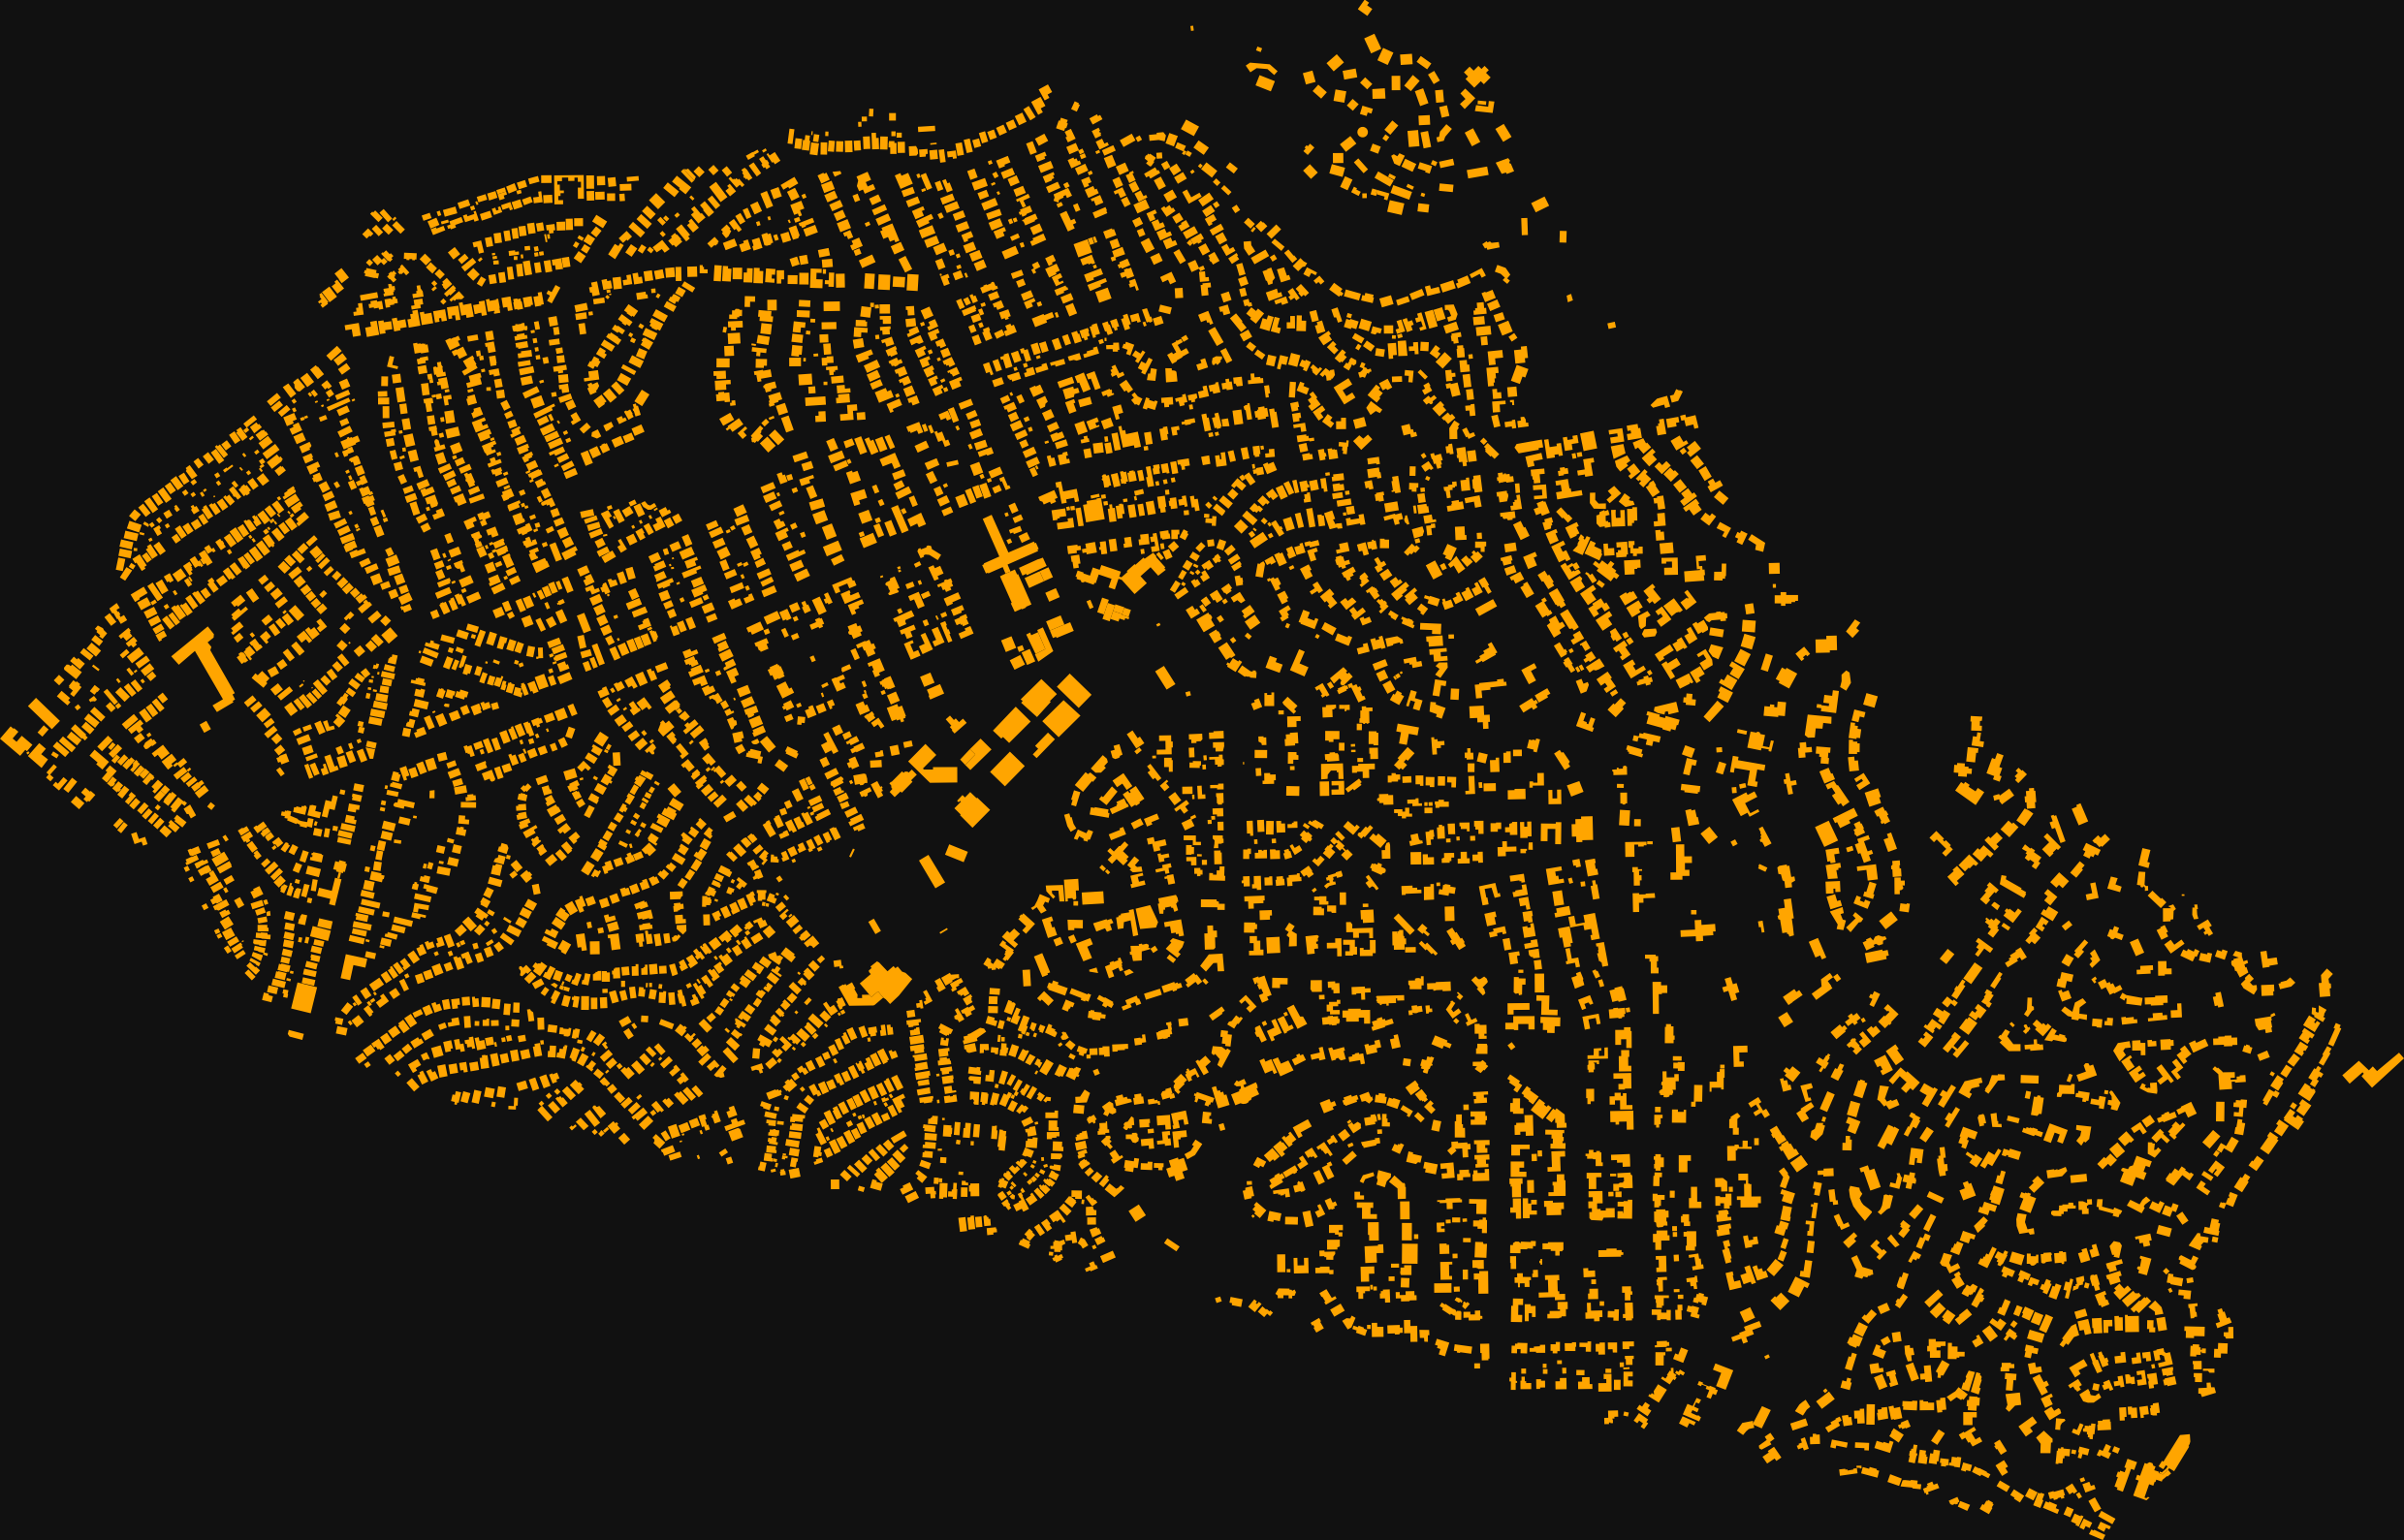

In [13]:
import os
from IPython.display import Image
tags = {"building": True}
gdf = ox.features_from_place("Piedmont, California, USA", tags)
gdf_proj = ox.project_gdf(gdf)
img_folder = "./figures"
if not os.path.exists(img_folder):
    os.makedirs(img_folder)
extension = 'png'
size = 400
fp = f"./{img_folder}/piedmont_bldgs.{extension}"
fig, ax = ox.plot_footprints(gdf_proj, filepath=fp, dpi=400, save=True, show=False, close=True)
Image(fp, height=size, width=size)

In [14]:
gdf_save = gdf.map(lambda x: str(x) if isinstance(x, list) else x)

<Axes: >

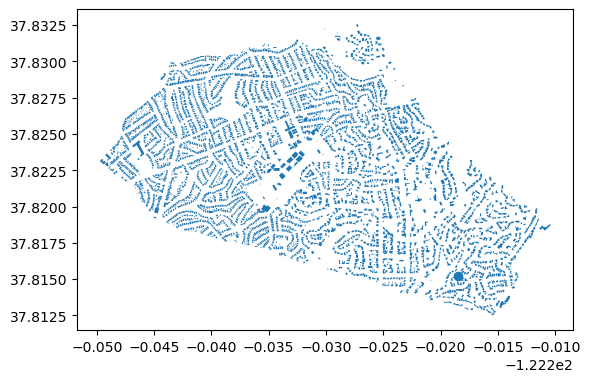

In [16]:
gdf_save.plot()

In [ ]:
# gdf_save.drop(labels="nodes", axis=1).to_file("./data/piedmont_bldgs.gpkg", driver="GPKG")

In [ ]:
# calculate the area in projected units (meters) of each building footprint, then display first five
areas = gdf_proj.area
areas.head()

# Download POI

In [17]:
# get all building footprints in some neighborhood
# `True` means retrieve any object with this tag, regardless of value
place = "SoHo, New York, NY"
# tags = {"leisure": "park"}
tags = {"amenity": True, "landuse": ["retail", "commercial"], "highway": "bus_stop"}
gdf = ox.features_from_place("Piedmont, California, USA", tags)
gdf.shape

(154, 72)

In [19]:

# view just the banks
gdf[gdf["amenity"] == "bank"].dropna(axis=1, how="any")

amenity             name  \
element_type osmid                                 
node         2810181540    bank         Citibank   
way          276424028     bank  Bank of America   
             285549437     bank      Wells Fargo   

                                                                  geometry  \
element_type osmid                                                           
node         2810181540                        POINT (-122.23256 37.82515)   
way          276424028   POLYGON ((-122.23259 37.82492, -122.23252 37.8...   
             285549437   POLYGON ((-122.23148 37.82467, -122.23133 37.8...   

                                   brand brand:wikidata     brand:wikipedia  
element_type osmid                                                           
node         2810181540         Citibank        Q857063         en:Citibank  
way          276424028   Bank of America        Q487907  en:Bank of America  
             285549437       Wells Fargo        Q744149      en:Wells Fargo

In [18]:
# view just the bus stops
gdf[gdf["highway"] == "bus_stop"].dropna(axis=1, how="any").head()

name  \
element_type osmid                                            
node         4071030440  Park Boulevard & Saint James Drive   
             5845148873     Hampton Road & Sandringham Road   
             5845152990     Hampton Road & Sandringham Road   
             5845153014       Hampton Road & Seaview Avenue   
             5845153034       Hampton Road & Seaview Avenue   

                                            geometry  bus   highway  \
element_type osmid                                                    
node         4071030440  POINT (-122.21517 37.81248)  yes  bus_stop   
             5845148873  POINT (-122.21492 37.81822)  yes  bus_stop   
             5845152990  POINT (-122.21459 37.81818)  yes  bus_stop   
             5845153014  POINT (-122.22303 37.81763)  yes  bus_stop   
             5845153034  POINT (-122.22265 37.81779)  yes  bus_stop   

                            network public_transport    ref route_ref  
element_type osmid                                                     
node         4071030440  AC Transit         platform  57544  V;33;688  
             5845148873  AC Transit         platform  53832        33  
             5845152990  AC Transit         platform  50830        33  
             5845153014  AC Transit         platform  53865        33  
             5845153034  AC Transit         platform  53238        33

<Axes: >

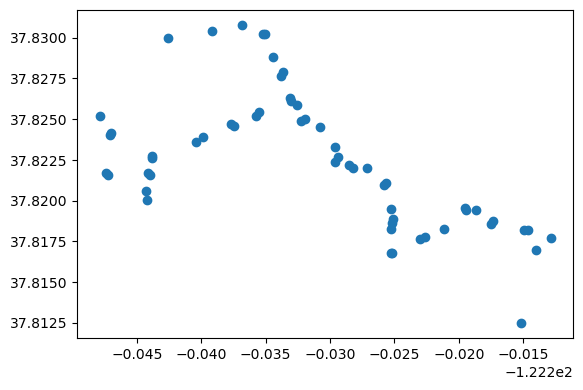

In [20]:
gdf[gdf["highway"] == "bus_stop"].plot()

# Analyze street (node) centrality
Common measure of centality:
1. Degree centrality: The more neighbours a given node has, the greater is its influence. Refering to the degree of a given node in the graph representing a social network.
2. Closeness centrality: Nodes that are able to reach other nodes via short paths, or who are “more reachable” by other nodes via shorter paths, are in more favoured positions. Such nodes are “central” to the network as they can reach the whole network more quickly than non-central nodes.
3. Betweeness centrality: For each pair of nodes in a social network, consider one of the shortest paths- all nodes in this path are intermediaries. The node that belongs to the shortest paths between the maximum number of such communications, is a special node — it is a potential deal maker and is in a special position since most other nodes have to channel their communications through it. Such a node has a high betweenness centrality.
More Reading [Link](https://medium.com/@asharayshetty/centrality-in-graph-theory-d57863a8b683)

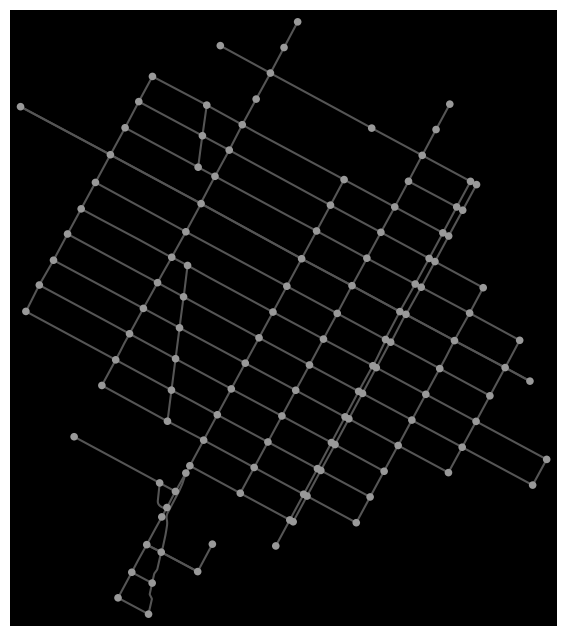

In [9]:
# download and project a street network
G = ox.graph_from_address(
    address="350 5th Ave, New York, NY",
    dist=1000,
    dist_type="network",
    network_type="drive",
)
G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, bgcolor='k', node_size=30, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

In [10]:
# node closeness centrality
node_centrality = nx.closeness_centrality(G)

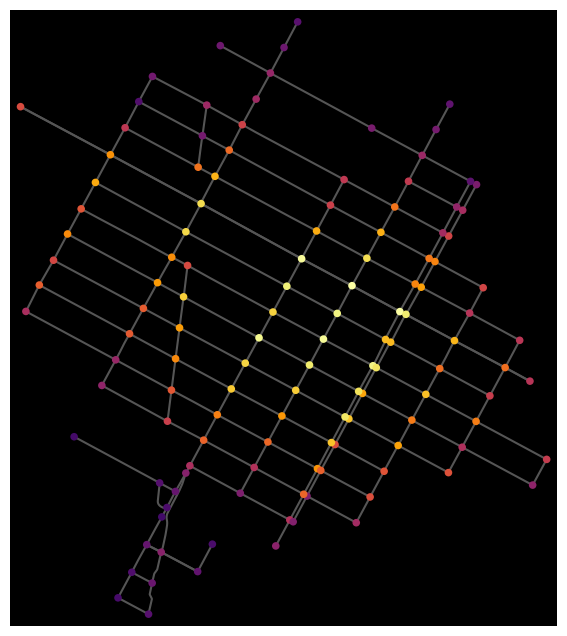

In [14]:
# plot it
df = pd.DataFrame(data=pd.Series(node_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='inferno', start=0.2)
df = df.reindex(G.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(G, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

### Edge Centrality

In [15]:
# edge closeness centrality: convert graph to a line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

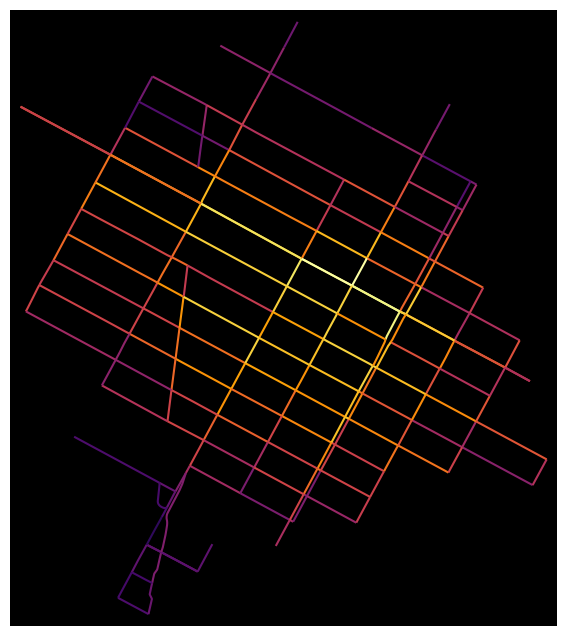

In [19]:
# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in G.edges()]

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(G, bgcolor='k',  node_size=0, node_color='w', node_edgecolor='gray', node_zorder=2,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

# Course work
Try to get the betweeness centrality of the streets